# **A practice notebook based on "Interrupted time-series model tutorial" by Harrison Curtis**

In [21]:
# Import neccesary libraries
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from utils import rcspline_eval, h, RR_hdi_calculator
from model import run_mod

import warnings
warnings.filterwarnings('ignore')

## Overview

- A Bayesian workflow of an ITS analysis, inspired by Bernal, Cummins, Gasparrini, (2017) and the Chapter 2 of Frank Harrell textbook (see resources);
- Use Restricted Cubic Spline (RCS - Devlin & Weeks, 1986) specially;
- And RCS with cyclical trend by Bhaskaran et al., 2013;
- Focus on the statistical estimation of a causal estimand Lundberg et al. (2021), specifcally the risk ratio difference between pre and post-intervention.

## Data description and importing

- Data taken from Barone-Adesi et al. (2011);
- They use ITS design experiment to determine the causal effect of a nation wide regulation on smoking in Italy on the "*standardised rate of acute coronary heart event cases (ACE)*";
- Specially focus on region Sicily.

In [22]:

# Load data
df = pd.read_csv("https://raw.githubusercontent.com/HPCurtis/Datasets/main/sicily.csv")

# Add datetime for ploting
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Intervention date
intervention_time = df.time[36]
intervention_date = df.date[36]

df.head()

,Unnamed: 0,year,month,aces,time,smokban,pop,stdpop,rate,date
0,1,2002,1,728,1,0,364277.4,379875.3,191.641836,2002-01-01
1,2,2002,2,659,2,0,364277.4,376495.5,175.035293,2002-02-01
2,3,2002,3,791,3,0,364277.4,377040.8,209.791619,2002-03-01
3,4,2002,4,734,4,0,364277.4,377116.4,194.634866,2002-04-01
4,5,2002,5,757,5,0,364277.4,377383.4,200.591759,2002-05-01


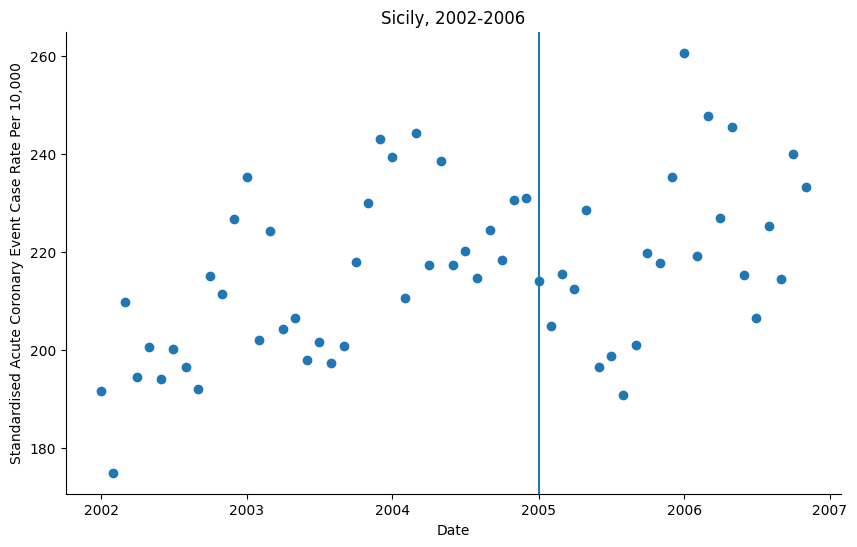

In [23]:
# Visualise the ACE data.
_, ax = plt.subplots(figsize=(10, 6))
plt.scatter(x=df.date, y=df.rate)
plt.title("Sicily, 2002-2006")
plt.ylabel('Standardised Acute Coronary Event Case Rate Per 10,000')
plt.xlabel('Date')
plt.axvline(intervention_date)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Model overview

Both models fundamentally are a form of Poisson Regression that models the rate of ACE using restricted cubic splines (RCS) and offset term. The difference between the two models is that the second model adds cyclical terms in the form of sin and cosine functions to model an assumed 12 month seasonality period.

### RCS Model

```python
y ~ Poisson(lambda)
lambda = exp(alpha + offset(z) + f(x) + level_change * beta_5)

    f(x) = sum(beta_k, phi_k(x)) for k in [1,4]
    alpha ~ Normal(0, 10)
    beta_k ~ Normal(0, 10) for k in [1,5]
    offset(z) = log(z)
    level_change = 1 if x >= 37 else 0
```

### RCS Model with cyclic trend

```python
y ~ Poisson(lambda)
lambda = exp(alpha + offset(z) + f(x) + COS + SIN + level_change * beta_7)

    f(x) = sum(beta_k, phi_k(x)) for k in [1,4]
    COS = sin(2 * pi * x / 12) * beta_5
    SIN = cos(2 * pi * x / 12) * beta_66
    alpha ~ Normal(0, 10)
    beta_k ~ Normal(0, 10) for k in [1,7]
    offset(z) = log(z)
    level_change = 1 if x >= 37 else 0
```

## Generate model design matrices

In [24]:
# Impact component (level change here) is the column of design matrix
# that estimates the parameter for the causal effect
level_change = (df.time >= 37).astype(int)

# Generate design matrices for rcs model and rcs with cyclical components
dm, knots = rcspline_eval(df.time, nk=6)
dm_cyl = h(df.time, knots=knots)

# Add causal parameter column to each model matrix
dm = np.column_stack((dm, level_change))
dm_cyl = np.column_stack((dm_cyl, level_change))

# Add offset to model matrix to deal with overdisperison
offset = np.log(df['stdpop']).values

In [25]:
# Fit PyMC models stored in model.py run_mod function
trace, model_rcs = run_mod(dm = dm, df = df, offset = offset)
trace_cyl, model_cyl = run_mod(dm = dm_cyl, df = df, offset = offset)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

## Posterior checks

In [26]:
# Output MCMC summaries for model parameters rcs only model
az.summary(trace, var_names=['alpha', 'beta'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-7.539,0.019,-7.576,-7.504,0.000,0.000,1635.0,1769.0,1.00
beta[0],0.057,0.022,0.016,0.103,0.001,0.001,1015.0,1155.0,1.01
beta[1],-0.180,0.086,-0.358,-0.019,0.003,0.002,977.0,1141.0,1.01
beta[2],0.260,0.150,-0.031,0.561,0.005,0.003,987.0,1152.0,1.00
beta[3],-0.241,0.183,-0.595,0.115,0.005,0.004,1182.0,1634.0,1.00
beta[4],-0.106,0.061,-0.220,0.014,0.001,0.001,1853.0,1947.0,1.00


In [27]:
# Output MCMC summaries for model parameters rcs only model
az.summary(trace_cyl, var_names=['alpha', 'beta'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-7.541,0.019,-7.580,-7.506,0.000,0.000,1929.0,2491.0,1.0
beta[0],0.054,0.022,0.011,0.097,0.001,0.000,1102.0,1813.0,1.0
beta[1],-0.164,0.085,-0.330,0.002,0.003,0.002,1058.0,1595.0,1.0
beta[2],0.231,0.148,-0.057,0.514,0.005,0.003,1059.0,1641.0,1.0
beta[3],-0.215,0.178,-0.551,0.145,0.005,0.003,1395.0,2086.0,1.0
beta[4],0.032,0.013,0.005,0.057,0.000,0.000,3191.0,2525.0,1.0
beta[5],0.038,0.013,0.012,0.063,0.000,0.000,3355.0,2403.0,1.0
beta[6],-0.130,0.062,-0.250,-0.009,0.001,0.001,2806.0,2596.0,1.0


array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

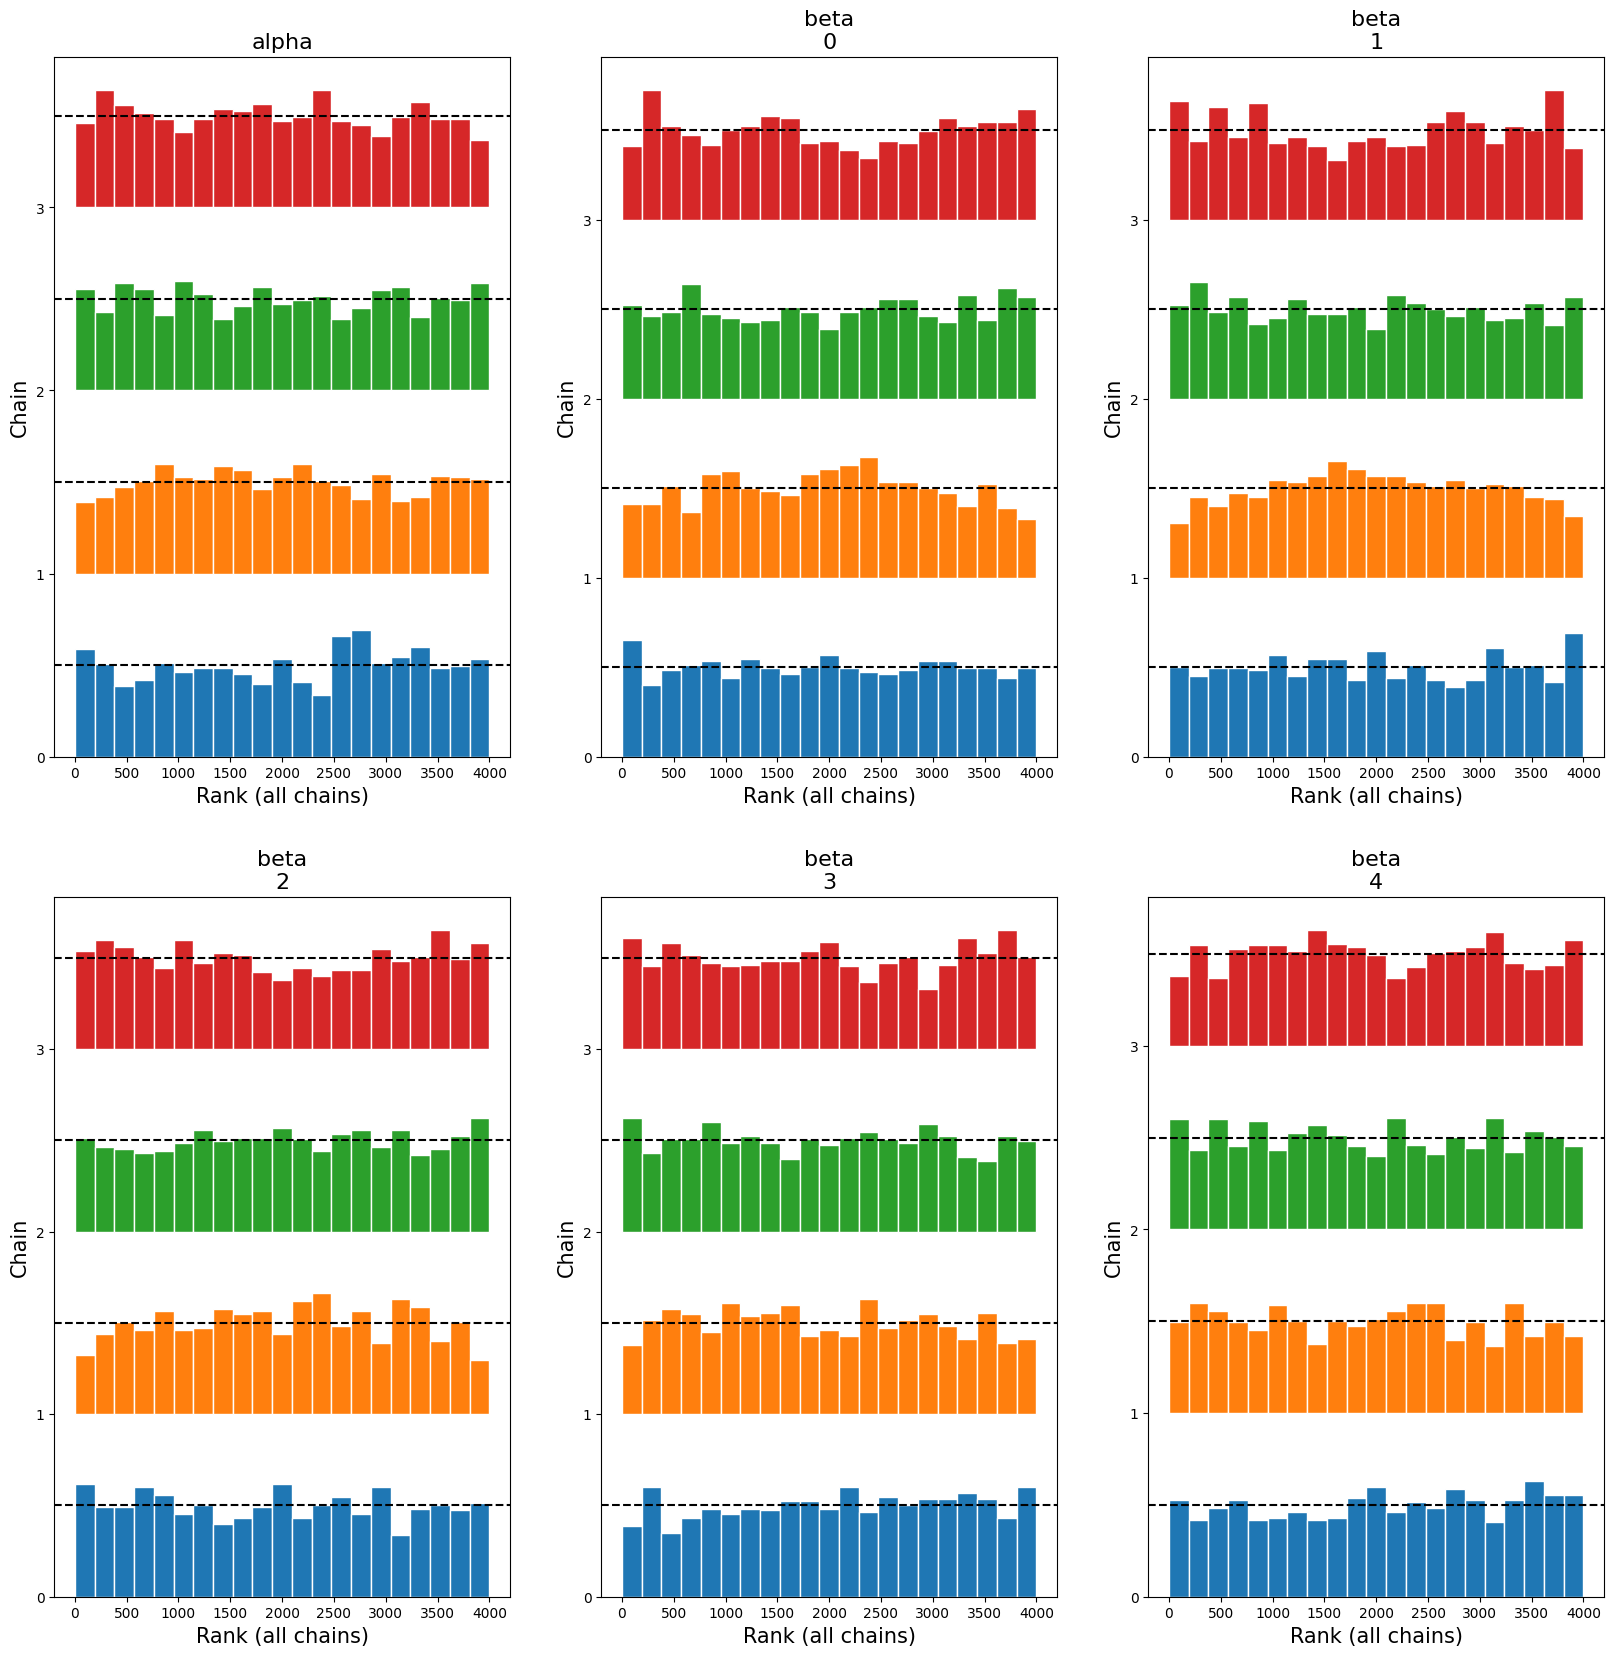

In [28]:
az.plot_rank(trace, var_names=['alpha', 'beta'], figsize=(20,20))

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

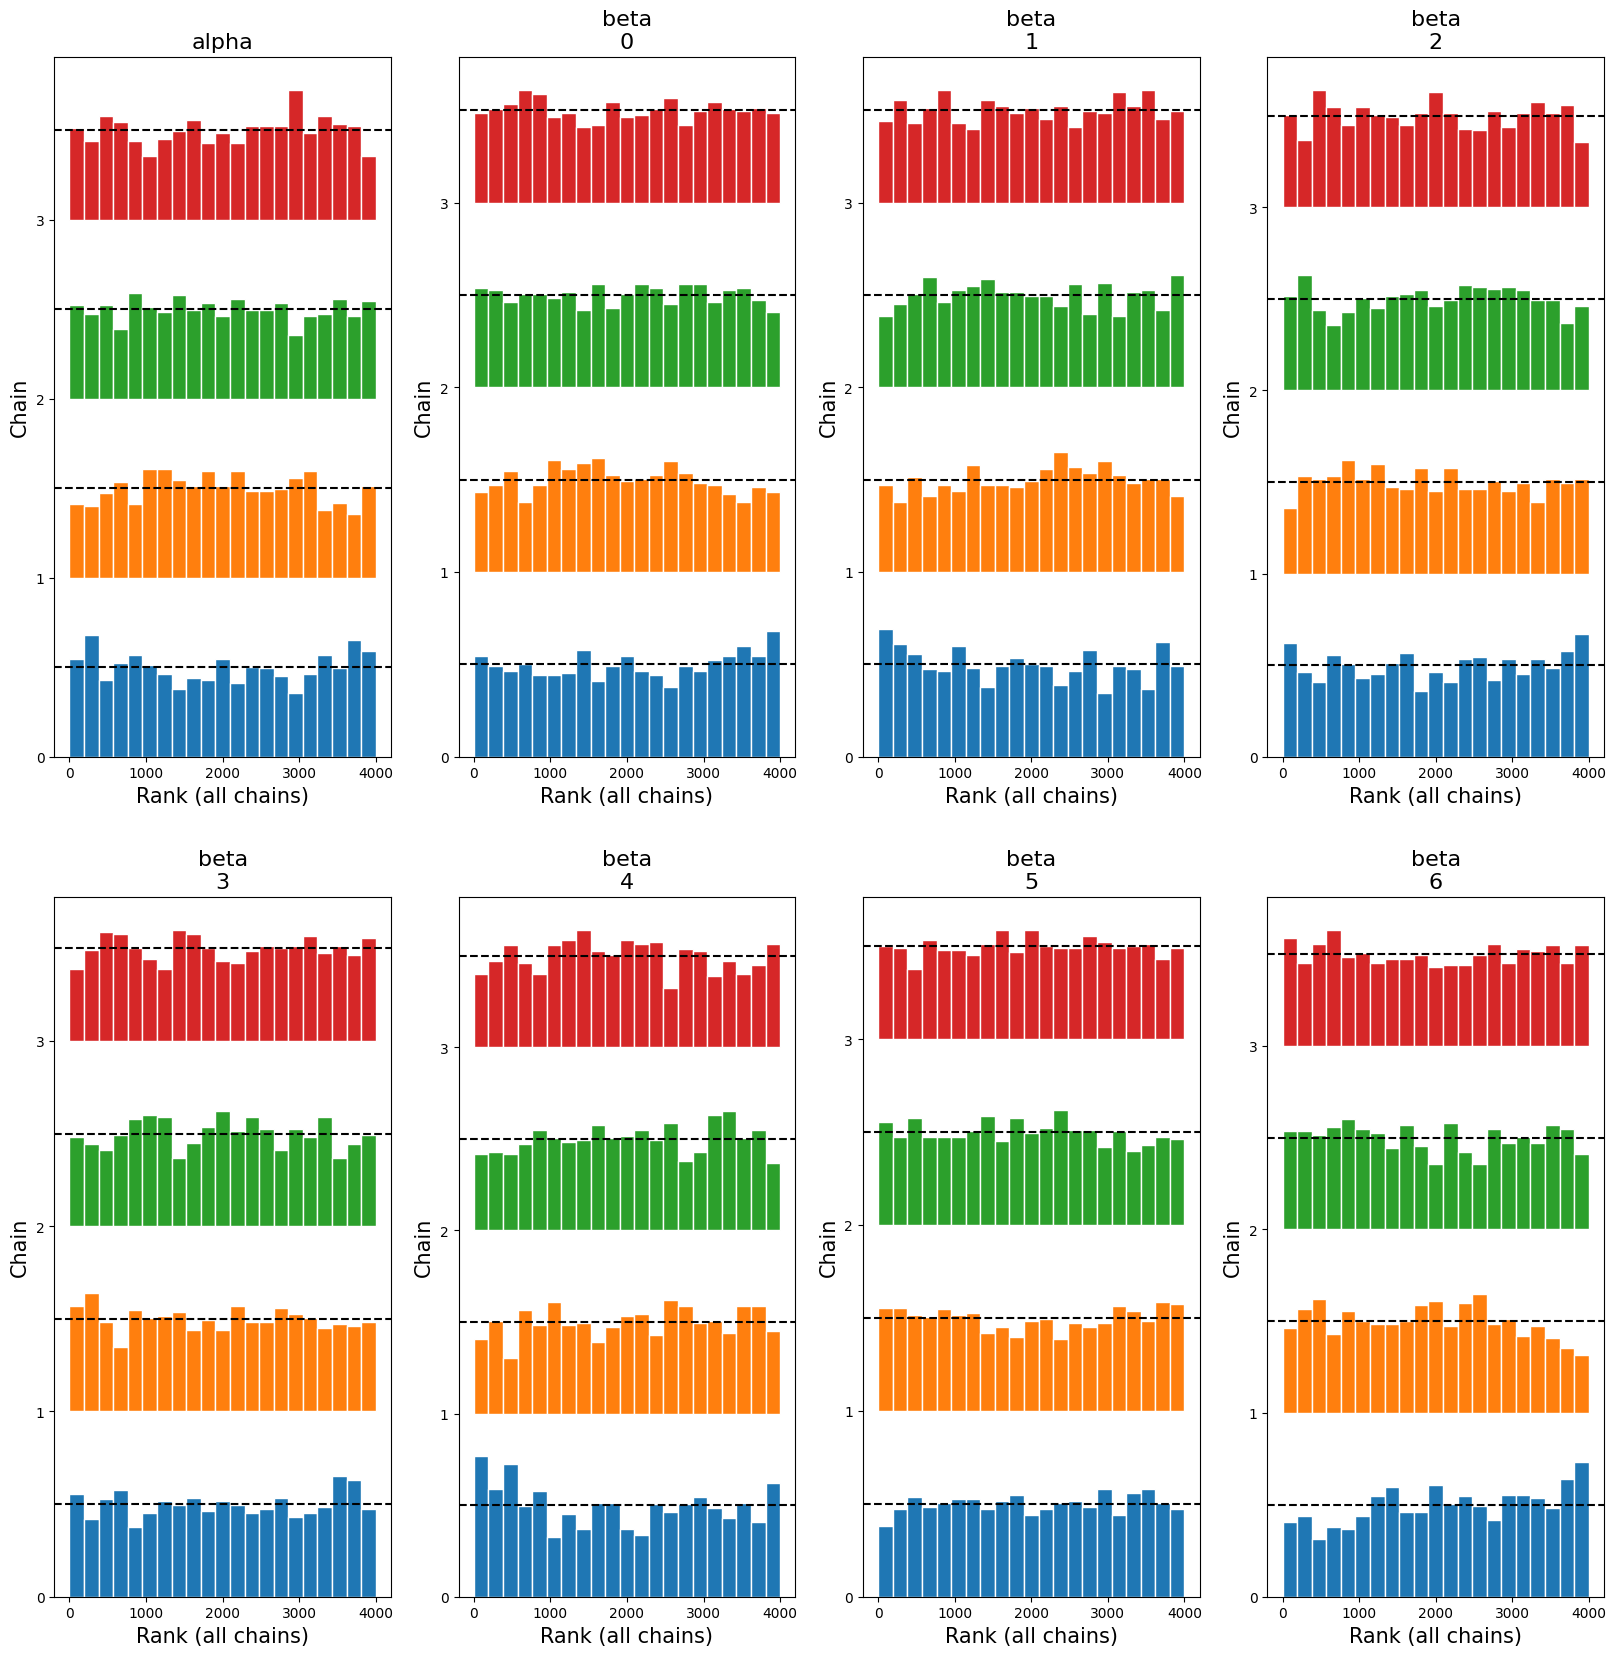

In [29]:
az.plot_rank(trace_cyl, var_names=['alpha', 'beta'], figsize=(20,20))

- Good effective sample size (ESS) for bulk;
- tail >= 400;
- Rhat all at 1.0 -> model had converged;
- No issue, or deformity in the chains away from uniformity.

## Model fit

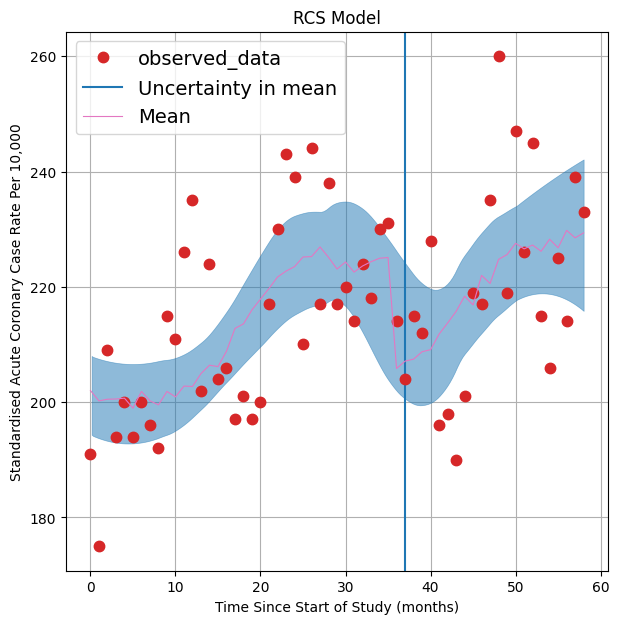

In [30]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=trace, y="y", num_samples=500, axes=ax, kind_model="hdi", y_model="lamda")
plt.ylabel("Standardised Acute Coronary Case Rate Per 10,000")
plt.xlabel("Time Since Start of Study (months)")
plt.title("RCS Model")
plt.axvline(intervention_time)

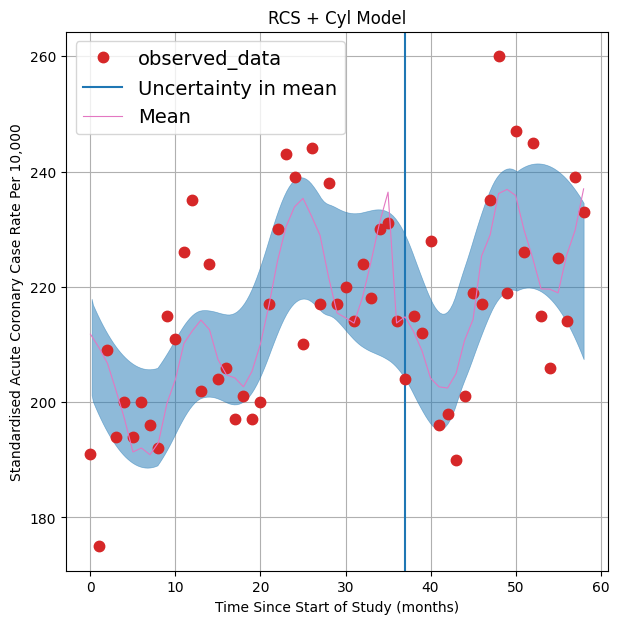

In [31]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=trace_cyl, y="y", num_samples=500, axes=ax, kind_model="hdi", y_model="lamda")
#plt.axvline(intervention_date);
plt.ylabel('Standardised Acute Coronary Case Rate Per 10,000')
plt.xlabel("Time Since Start of Study (months)")
plt.title("RCS + Cyl Model")
plt.axvline(intervention_time)

## Posterior predictive checks

In [32]:
# Using model objects  posterior preicitve simulations
with model_rcs:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=1)
with model_cyl:
    pm.sample_posterior_predictive(trace_cyl, extend_inferencedata=True, random_seed=1)

Sampling: [y]


Output()

Sampling: [y]


Output()

<Axes: xlabel='y'>

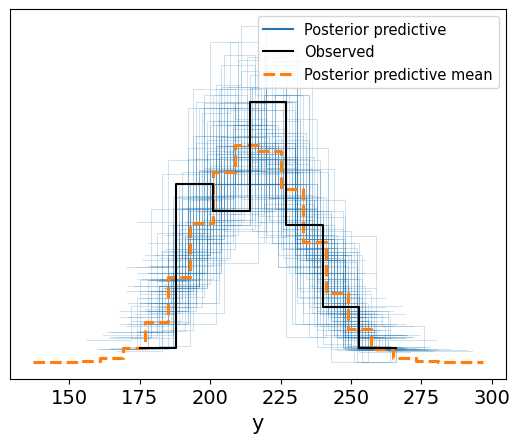

In [33]:
# Plot posterior predictive check plot.
az.plot_ppc(trace, num_pp_samples=100)

<Axes: xlabel='y'>

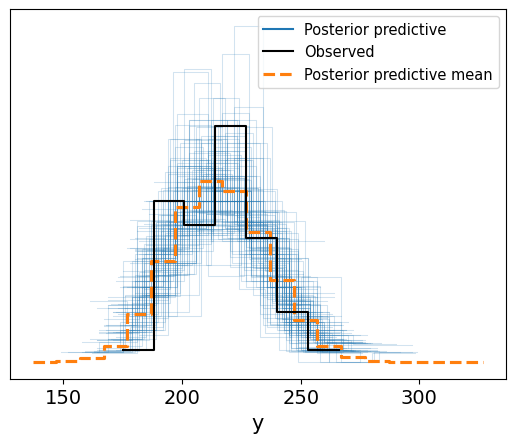

In [34]:
# Plot posterior predictive check.
az.plot_ppc(trace_cyl, num_pp_samples=100)

## Causal Inference estimates

In [35]:
# Calculate Risk Ratio highest density interval (default 95%) for the impact component of the ITS model.
hdi_rcs_lower, hdi_rcs_higher = RR_hdi_calculator(trace=trace.posterior.beta[:,:,4])
hdi_cyl_lower, hdi_cyl_higher = RR_hdi_calculator(trace=trace_cyl.posterior.beta[:,:,6])

# Risk ratio show decrease for relative risk after intervention of smoking policy in both models
print("Risk Ratio for the RCS model",
      round(np.exp(trace.posterior.beta[:,:,4].mean().values), 2), "\u00B1", f"CrI[{hdi_rcs_higher},{hdi_rcs_lower}]")
print("Risk Ratio for the RCS with cyclic trend (seasonality) model",
      round(np.exp(trace_cyl.posterior.beta[:,:,6].mean().values), 2), "\u00B1", f"CrI[{hdi_cyl_higher},{hdi_cyl_lower}]")

Risk Ratio for the RCS model 0.9 ± CrI[1.01,0.8]
Risk Ratio for the RCS with cyclic trend (seasonality) model 0.88 ± CrI[0.99,0.78]


## Models comparison

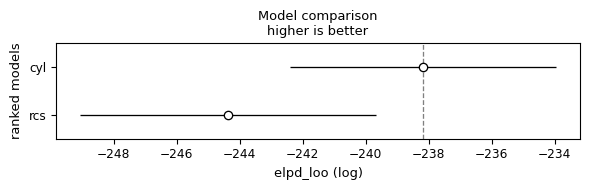

In [36]:
# Use arviz loo comparion methods using log-likelihoods calculated in the run_mod() call.
df_comp_loo = az.compare({"rcs": trace, "cyl": trace_cyl})
az.plot_compare(df_comp_loo, insample_dev=False)
plt.tight_layout()

## Resources

1. Author's Linked In post: <https://www.linkedin.com/posts/harrison-curtis-data-professional_itssplinepymcitsipynb-at-main-hpcurtis-activity-7331999835169959938-wID5>;
2. Github repo: <https://github.com/HPCurtis/ITS_spline_pymc/blob/main/its.ipynb>;
3. Frank Harrell motivation: <https://hbiostat.org/rmsc/>;
4. Fourier in `PyMC`: <https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.mmm.fourier.html#module-pymc_marketing.mmm.fourier>;
5. Basis spline regression from `CausalPy` (also read more of `Patsy` is recommend): <https://causalpy.readthedocs.io/en/latest/notebooks/rd_skl.html#using-basis-splines>.